In [4]:
import os
import time
import tensorflow as tf
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
print(tf.__version__)

2.14.0


In [7]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3604467648816386346
xla_global_id: -1
]


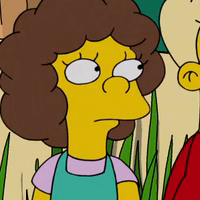

In [4]:
import PIL
image="./simpsons_dataset/cropped/1008.png"
img=PIL.Image.open(image)
img

In [5]:
# Paths
INPUT_DATA_DIR = "./simpsons_dataset/cropped/"
# OUTPUT_DIR = './{date:%Y-%m-%d_%H:%M:%S}/'.format(date=datetime.datetime.now())
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)
OUTPUT_DIR = ""

In [6]:
# Hyperparameters
IMAGE_SIZE = 128
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 32
EPOCHS = 100 # For better results increase this value 
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 5

# CONSTUIR EL GENERADOR Y DISCRIMINADOR

In [7]:
def generator(z, output_channel_dim, training):
    with tf.variable_scope("generator", reuse= not training):
        
        # 8x8x1024
        fully_connected = tf.layers.dense(z, 8*8*1024)
        fully_connected = tf.reshape(fully_connected, (-1, 8, 8, 1024))
        fully_connected = tf.nn.leaky_relu(fully_connected)

        # 8x8x1024 -> 16x16x512
        trans_conv1 = tf.layers.conv2d_transpose(inputs=fully_connected,
                                                 filters=512,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 name="trans_conv1")
        batch_trans_conv1 = tf.layers.batch_normalization(inputs = trans_conv1,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv1")
        trans_conv1_out = tf.nn.leaky_relu(batch_trans_conv1,
                                           name="trans_conv1_out")
        
        # 16x16x512 -> 32x32x256
        trans_conv2 = tf.layers.conv2d_transpose(inputs=trans_conv1_out,
                                                 filters=256,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 name="trans_conv2")
        batch_trans_conv2 = tf.layers.batch_normalization(inputs = trans_conv2,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv2")
        trans_conv2_out = tf.nn.leaky_relu(batch_trans_conv2,
                                           name="trans_conv2_out")
        
        # 32x32x256 -> 64x64x128
        trans_conv3 = tf.layers.conv2d_transpose(inputs=trans_conv2_out,
                                                 filters=128,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 name="trans_conv3")
        batch_trans_conv3 = tf.layers.batch_normalization(inputs = trans_conv3,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv3")
        trans_conv3_out = tf.nn.leaky_relu(batch_trans_conv3,
                                           name="trans_conv3_out")
        
        # 64x64x128 -> 128x128x64
        trans_conv4 = tf.layers.conv2d_transpose(inputs=trans_conv3_out,
                                                 filters=64,
                                                 kernel_size=[5,5],
                                                 strides=[2,2],
                                                 padding="SAME",
                                                 name="trans_conv4")
        batch_trans_conv4 = tf.layers.batch_normalization(inputs = trans_conv4,
                                                          training=training,
                                                          epsilon=EPSILON,
                                                          name="batch_trans_conv4")
        trans_conv4_out = tf.nn.leaky_relu(batch_trans_conv4,
                                           name="trans_conv4_out")
        
        # 128x128x64 -> 128x128x3
        logits = tf.layers.conv2d_transpose(inputs=trans_conv4_out,
                                            filters=3,
                                            kernel_size=[5,5],
                                            strides=[1,1],
                                            padding="SAME",
                                            name="logits")
        out = tf.tanh(logits, name="out")
        return out



In [8]:
def discriminator(x, reuse):
    with tf.variable_scope("discriminator", reuse=reuse): 
        
        # 128*128*3 -> 64x64x64 
        conv1 = tf.layers.conv2d(inputs=x,
                                 filters=64,
                                 kernel_size=[5,5],
                                 strides=[2,2],
                                 padding="SAME",
                                 name='conv1')
        batch_norm1 = tf.layers.batch_normalization(conv1,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm1')
        conv1_out = tf.nn.leaky_relu(batch_norm1,
                                     name="conv1_out")
        
        # 64x64x64-> 32x32x128 
        conv2 = tf.layers.conv2d(inputs=conv1_out,
                                 filters=128,
                                 kernel_size=[5, 5],
                                 strides=[2, 2],
                                 padding="SAME",
                                 name='conv2')
        batch_norm2 = tf.layers.batch_normalization(conv2,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm2')
        conv2_out = tf.nn.leaky_relu(batch_norm2,
                                     name="conv2_out")
        
        # 32x32x128 -> 16x16x256  
        conv3 = tf.layers.conv2d(inputs=conv2_out,
                                 filters=256,
                                 kernel_size=[5, 5],
                                 strides=[2, 2],
                                 padding="SAME",
                                 name='conv3')
        batch_norm3 = tf.layers.batch_normalization(conv3,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm3')
        conv3_out = tf.nn.leaky_relu(batch_norm3,
                                     name="conv3_out")
        
        # 16x16x256 -> 16x16x512
        conv4 = tf.layers.conv2d(inputs=conv3_out,
                                 filters=512,
                                 kernel_size=[5, 5],
                                 strides=[1, 1],
                                 padding="SAME",
                                 name='conv4')
        batch_norm4 = tf.layers.batch_normalization(conv4,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm4')
        conv4_out = tf.nn.leaky_relu(batch_norm4,
                                     name="conv4_out")
        
        # 16x16x512 -> 8x8x1024
        conv5 = tf.layers.conv2d(inputs=conv4_out,
                                filters=1024,
                                kernel_size=[5, 5],
                                strides=[2, 2],
                                padding="SAME",
                                name='conv5')
        batch_norm5 = tf.layers.batch_normalization(conv5,
                                                    training=True,
                                                    epsilon=EPSILON,
                                                    name='batch_norm5')
        conv5_out = tf.nn.leaky_relu(batch_norm5,
                                     name="conv5_out")

        flatten = tf.reshape(conv5_out, (-1, 8*8*1024))
        logits = tf.layers.dense(inputs=flatten,
                                 units=1,
                                 activation=None)
        out = tf.sigmoid(logits)
        return out, logits


# Modelo de perdida

In [9]:
def model_loss(input_real, input_z, output_channel_dim):
    g_model = generator(input_z, output_channel_dim, True)

    noisy_input_real = input_real + tf.random_normal(shape=tf.shape(input_real),
                                                     mean=0.0,
                                                     stddev=random.uniform(0.0, 0.1),
                                                     dtype=tf.float32)
    
    d_model_real, d_logits_real = discriminator(noisy_input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*random.uniform(0.9, 1.0)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = tf.reduce_mean(0.5 * (d_loss_real + d_loss_fake))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


In [10]:
def model_optimizers(d_loss, g_loss):
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=LR_D, beta1=BETA1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=LR_G, beta1=BETA1).minimize(g_loss, var_list=g_vars)  
    return d_train_opt, g_train_opt


In [11]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate_G = tf.placeholder(tf.float32, name="lr_g")
    learning_rate_D = tf.placeholder(tf.float32, name="lr_d")
    return inputs_real, inputs_z, learning_rate_G, learning_rate_D


In [12]:
def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMAGE_SIZE, IMAGE_SIZE))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray(image_array)
        image.save("results/"+name+"_"+str(epoch)+"_"+str(index)+".png") 
    plt.savefig("results/"+name+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()


In [13]:
def test(sess, input_z, out_channel_dim, epoch):
    example_z = np.random.uniform(-1, 1, size=[SAMPLES_TO_SHOW, input_z.get_shape().as_list()[-1]])
    samples = sess.run(generator(input_z, out_channel_dim, False), feed_dict={input_z: example_z})
    sample_images = [((sample + 1.0) * 127.5).astype(np.uint8) for sample in samples]
    show_samples(sample_images, OUTPUT_DIR + "samples", epoch)


In [14]:
def summarize_epoch(epoch, duration, sess, d_losses, g_losses, input_z, data_shape):
    minibatch_size = int(data_shape[0]//BATCH_SIZE)
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-minibatch_size:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-minibatch_size:])))
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(OUTPUT_DIR + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()
    test(sess, input_z, data_shape[3], epoch)


In [15]:
def get_batches(data):
    batches = []
    for i in range(int(data.shape[0]//BATCH_SIZE)):
        batch = data[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        augmented_images = []
        for img in batch:
            image = Image.fromarray(img)
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
            augmented_images.append(np.asarray(image))
        batch = np.asarray(augmented_images)
        normalized_batch = (batch / 127.5) - 1.0
        batches.append(normalized_batch)
    return batches


In [16]:
from tqdm import tqdm

def train(get_batches, data_shape, checkpoint_to_load=None):
    input_images, input_z, lr_G, lr_D = model_inputs(data_shape[1:], NOISE_SIZE)
    d_loss, g_loss = model_loss(input_images, input_z, data_shape[3])
    d_opt, g_opt = model_optimizers(d_loss, g_loss)
    
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        epoch = 0
        iteration = 0
        d_losses = []
        g_losses = []
        
        for epoch in range(EPOCHS):        
            epoch += 1
            start_time = time.time()

            #  Aquí se crea la barra de progreso con tqdm
            with tqdm(total=len(get_batches), desc="Epoch {}/{}".format(epoch, EPOCHS), unit='batches') as pbar:
                for batch_images in get_batches:
                    iteration += 1
                    batch_z = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_SIZE))
                    _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: LR_D})
                    _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: LR_G})
                    d_losses.append(d_loss.eval({input_z: batch_z, input_images: batch_images}))
                    g_losses.append(g_loss.eval({input_z: batch_z}))

                    # Aquí se actualiza la barra de progreso
                    pbar.set_postfix({"D Loss": np.mean(d_losses[-iteration:]), "G Loss": np.mean(g_losses[-iteration:])})
                    pbar.update()

            summarize_epoch(epoch, time.time()-start_time, sess, d_losses, g_losses, input_z, data_shape)


In [17]:
def add_noise(img):
    VARIABILITY=50
    deviation=VARIABILITY*random.random()
    noise=np.random.normal(0,deviation,img.shape)
    img+=noise
    np.clip(img,0.,255.)
    return(img)

In [18]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Starting the training


Input: (9877, 128, 128, 3)


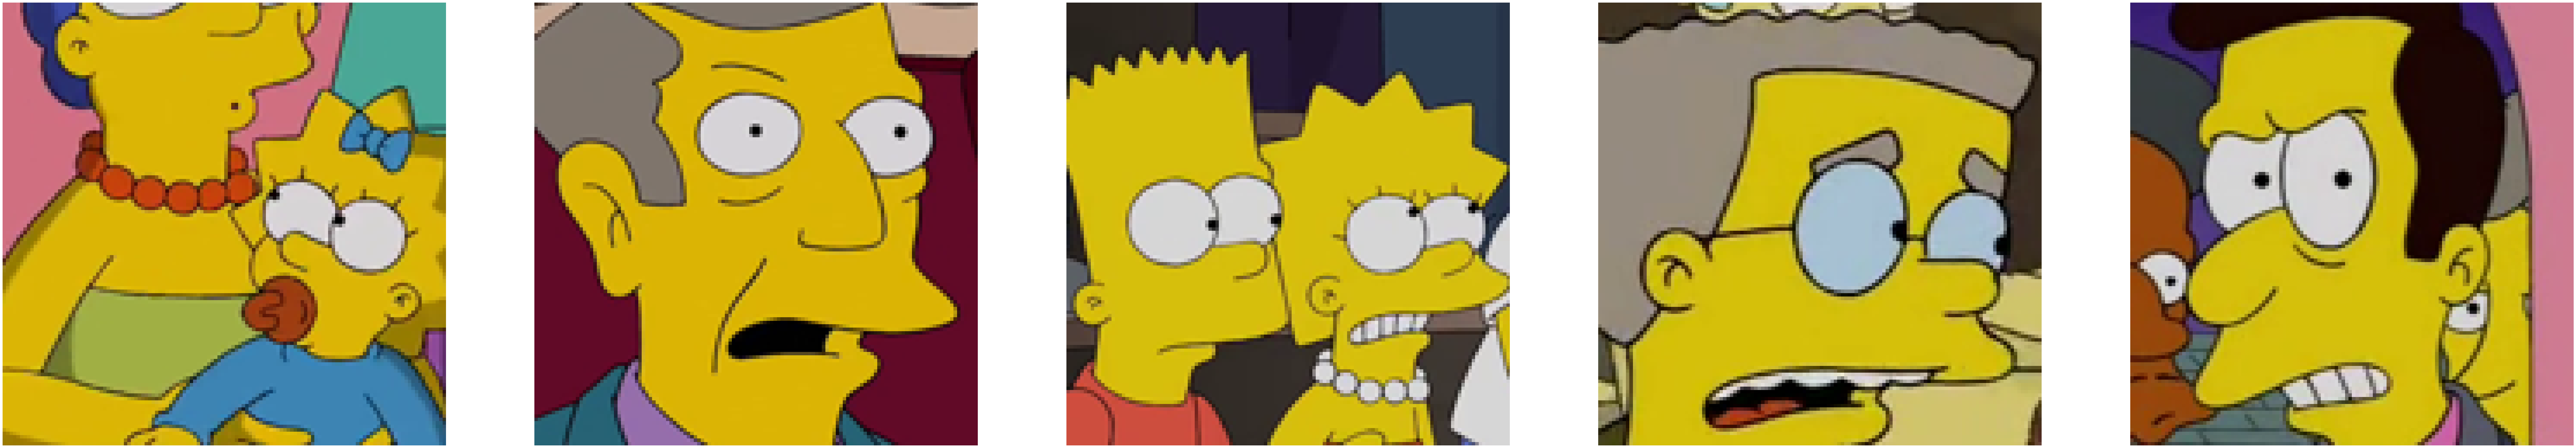

C:\Users\PARK JONGHYUN\AppData\Local\Temp\ipykernel_50548\2855673783.py:5: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  fully_connected = tf.layers.dense(z, 8*8*1024)
C:\Users\PARK JONGHYUN\AppData\Local\Temp\ipykernel_50548\2855673783.py:10: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  trans_conv1 = tf.layers.conv2d_transpose(inputs=fully_connected,
C:\Users\PARK JONGHYUN\AppData\Local\Temp\ipykernel_50548\2855673783.py:16: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  batch_trans_conv1 = tf.layers.batch_normalization(inputs = trans_c

KeyboardInterrupt: 

In [19]:
print("Starting the training")
input_images = np.asarray([np.asarray(Image.open(file).resize((IMAGE_SIZE, IMAGE_SIZE))) for file in glob(INPUT_DATA_DIR + '*')])
print ("Input: " + str(input_images.shape))

np.random.shuffle(input_images)

sample_images = random.sample(list(input_images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)

with tf.Graph().as_default():
    train(get_batches(input_images), input_images.shape)